In [11]:
import cv2, matplotlib, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rect_util as ru

p = {
    'max_matching_points': 400,
    'connection_distance': 60,
    'shift_delta': 2,
    'threshold_pixel_norm':  5,
    'threshold_pixel_counts': 0.001,
}
def match_kps(kp1, des1, kp2, des2):
    bf = cv2.BFMatcher(2)
    matches = bf.knnMatch(des1, des2, k=2)
    ratio = 0.3
    good = []
    for m, n, in matches:
        if m.distance < ratio * n.distance:
            good.append([m])
    return good

def cluster_matches(kp1, des1, kp2, des2, matches, n):
    vectors = []
    num_k = min(int(len(matches) / 3), n)
    dxw, dyw, wy=(100, 1000, 100)
    for m in matches:
        x1, y1 = kp1[m.queryIdx].pt
        x2, y2 = kp2[m.trainIdx].pt
        vectors.append([x1, x2, wy*y1, wy*y2, dxw * round((x2 - x1)), dyw*(round(y2 - y1))])
    npmat=np.array(vectors)
    criteria =(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(np.float32(npmat), num_k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
    cgg = [[] for i in range(num_k)]
    i = 0
    for l in label:
        cgg[l[0]].append(matches[i])
        i = i + 1
    return cgg, ret, label, [[c[0], c[1], c[2] / wy, c[3] / wy, int(round(c[4] / dxw)), int(round(c[5] / dyw))] for c in center]

def cluster_kps(kplist, n = 10, wy = 10.0):
    matt = []
    for kp in kplist:
        matt.append([kp.pt[0], kp.pt[1] * wy])
    num_k = min(int(len(kplist) / 3), n)
    if (num_k < 2):
        return [] if len(kplist) < 2 else [kplist]
    npmat=np.array(matt)
    criteria =(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(np.float32(npmat), num_k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
    kps = [[] for i in range(num_k)]
    i = 0
    for l in label:
        kps[l[0]].append(kplist[i])
        i += 1
    return kps

def binary_diff(imgr1, imgr2, tpn):
    _, diff_img = cv2.threshold(cv2.cvtColor(cv2.absdiff(imgr1, imgr2), cv2.COLOR_RGB2GRAY), tpn, 255, cv2.THRESH_BINARY)
    return diff_img

def around_diff_match(img1, r1, img2, r2, db, sv):
    grid = 36
    around_diff_rects = []
    #bottom
    gi = [0, 0, 0, 0]
    go = [0, 0, 0, 0]
    ad = [True, True, True, True]
    while ad[0] or ad[1] or ad[2] or ad[3]:
        #left
        if ad[0]:
            go[0] = min(gi[0] + grid, db[0])
            t1 = (r1[2] - go[0], r1[1] - gi[1], r1[2] - gi[2], r1[3] + gi[3])
            t2 = (r2[2] - go[0], r2[1] - gi[1], r2[2] - gi[2], r2[3] + gi[3])
            is_same, imgr1, imgr2, sv= ru.allclose(img1, t1, img2, t2, 0, sv)
            if not is_same:
                inner_rects = ru.marge_rects(ru.nonzero_rects(binary_diff(imgr1, imgr2, p['threshold_pixel_norm']), grid, grid, True), grid)
                wd = max([x[3] for x in inner_rects] + [0]) - min([x[1] for x in inner_rects] + [0])
                wr =  r1[3] - r1[1] + gi[1] + gi[3]
                if wd / wr >= 0.6:
                    ad[0] = False
                else:
                    around_diff_rects.extend(ru.shift_rects(inner_rects, (r1[2] - r1[0] - go[0], -gi[1])))
        if ad[0]:
            gi[0] = min(gi[0] + grid, db[0])
            ad[0] = gi[0] < db[0]
        
        #top
        if ad[1]:
            go[1] = min(gi[1] + grid, db[1])
            t1 = (r1[0] - gi[0], r1[1] - go[1], r1[2] + gi[2], r1[1] - gi[1])
            t2 = (r2[0] - gi[0], r2[1] - go[1], r2[2] + gi[2], r2[1] - gi[1])
            is_same, imgr1, imgr2, sv= ru.allclose(img1, t1, img2, t2, 0, sv)
            if not is_same:
                inner_rects = ru.marge_rects(ru.nonzero_rects(binary_diff(imgr1, imgr2, p['threshold_pixel_norm']), grid, grid, True), grid)
                wd = max([x[2] for x in inner_rects] + [0]) - min([x[0] for x in inner_rects] + [0])
                wr =  r1[2] - r1[0] + gi[0] + gi[2]
                if wd / wr >= 0.6:
                    ad[1] = False
                else:
                    around_diff_rects.extend(ru.shift_rects(inner_rects, (-gi[0], -go[1])))
        if ad[1]:
            gi[1] = min(gi[1] + grid, db[1])
            ad[1] = gi[1] < db[1]
        
        #right
        if ad[2]:
            go[2] = min(gi[2] + grid, db[2])
            t1 = (r1[2] + gi[2], r1[1] - gi[1], r1[2] + go[2], r1[3] + gi[3])
            t2 = (r2[2] + gi[2], r2[1] - gi[1], r2[2] + go[2], r2[3] + gi[3])
            is_same, imgr1, imgr2, sv= ru.allclose(img1, t1, img2, t2, 0, sv)
            if not is_same:
                inner_rects = ru.marge_rects(ru.nonzero_rects(binary_diff(imgr1, imgr2, p['threshold_pixel_norm']), grid, grid, True), grid)
                wd = max([x[3] for x in inner_rects] + [0]) - min([x[1] for x in inner_rects] + [0])
                wr =  r1[3] - r1[1] + gi[1] + gi[3]
                if wd / wr >= 0.6:
                    ad[2] = False
                else:
                    around_diff_rects.extend(ru.shift_rects(inner_rects, (r1[2] - r1[0] + gi[2], -gi[1])))
        if ad[2]:
            gi[2] = min(gi[2] + grid, db[2])
            ad[2] = gi[2] < db[2]
        
        #bottom
        if ad[3]:
            go[3] = min(gi[3] + grid, db[3])
            t1 = (r1[0] - gi[0], r1[3] + gi[3], r1[2] + gi[2], r1[3] + go[3])
            t2 = (r2[0] - gi[0], r2[3] + gi[3], r2[2] + gi[2], r2[3] + go[3])
            is_same, imgr1, imgr2, sv= ru.allclose(img1, t1, img2, t2, 0, sv)
            if not is_same:
                inner_rects = ru.marge_rects(ru.nonzero_rects(binary_diff(imgr1, imgr2, p['threshold_pixel_norm']), grid, grid, True), grid)
                wd = max([x[2] for x in inner_rects] + [0]) - min([x[0] for x in inner_rects] + [0])
                wr =  r1[2] - r1[0] + gi[0] + gi[2]
                if wd / wr >= 0.6:
                    ad[3] = False
                else:
                    around_diff_rects.extend(ru.shift_rects(inner_rects, (-gi[0], r1[3] - r1[1] + gi[3])))
        if ad[3]:
            gi[3] = min(gi[3] + grid, db[3])
            ad[3] = gi[3] < db[3]
    return ((gi[0], gi[1], gi[2], gi[3]), around_diff_rects)
    

def pixel_match(img1, matched_rects1, img2, matched_rects2, cv):
    rects1 = ru.clone(matched_rects1)
    rects2 = ru.clone(matched_rects2)
    result = []
    for i in range(len(rects1)):
        r1, r2, center = (rects1[i], rects2[i], cv[i])
        is_same, imgr1, imgr2, sv= ru.allclose(img1, r1, img2, r2, p['shift_delta'])
        inner_rects = []
        if not is_same:
            diff_img = binary_diff(imgr1, imgr2, p['threshold_pixel_norm'])
            inner_rects = ru.marge_rects(ru.nonzero_rects(diff_img, 32, 32, True), 32)
        else:
            inner_rects = []
        eb1 =  ru.expand(rects1, i, img1.shape)
        eb2 =  ru.expand(rects2, i, img2.shape)
        db = (
            min(r1[0] - eb1[0], r2[0] - eb2[0]),
            min(r1[1] - eb1[1], r2[1] - eb2[1]),
            min(eb1[2] - r1[2], eb2[2] - r2[2]),
            min(eb1[3] - r1[3], eb2[3] - r2[3]),
        )
        dbx, outer_rects = around_diff_match(img1, r1, img2, r2, db, sv)
        #print(r1, r2, db, dbx)
        if len(inner_rects) == 0 and len(outer_rects) == 0:
            result.append((True, [], []))
        if len(inner_rects) > 0 and len(outer_rects) == 0:
            result.append((False, ru.shift_rects(inner_rects, (r1[0], r1[1])), ru.shift_rects(inner_rects, (r2[0], r2[1]))))
        if len(inner_rects) == 0 and len(outer_rects) > 0:
            result.append((False, ru.shift_rects(outer_rects, (r1[0], r1[1])), ru.shift_rects(outer_rects, (r2[0], r2[1]))))
        if len(inner_rects) > 0 and len(outer_rects) > 0:
            inner_rects.extend(outer_rects)
            marged = ru.marge_rects(inner_rects, 32)
            result.append(
                (
                    False,
                    ru.shift_rects(marged, (r1[0], r1[1])),
                    ru.shift_rects(marged, (r2[0], r2[1]))
                )
            )
        rects1[i] = (r1[0] - dbx[0], r1[1] - dbx[1], r1[2] + dbx[2], r1[3] + dbx[3])
        rects2[i] = (r2[0] - dbx[0], r2[1] - dbx[1], r2[2] + dbx[2], r2[3] + dbx[3])
        #print((rects1[i], rects2[i]))
        
    return (result, rects1, rects2)


%matplotlib inline

use_canny = True

def detect_diff(suffix):
    print('')
    print('Start to process: ', suffix)
    img1=cv2.imread('img/actual/' + suffix)
    img2=cv2.imread('img/expected/' + suffix)
    
    # Pre-processes for features detection
    if use_canny:
        img_in1 = cv2.Canny(img1, 10, 40)
        img_in2 = cv2.Canny(img2, 10, 40)
    else:
        img_in1 = img1
        img_in2 = img2
    
    # Detects Keypoints and Feature Descriptors
    akaze = cv2.AKAZE_create()
    kp1, des1 = akaze.detectAndCompute(img_in1, None)
    kp2, des2 = akaze.detectAndCompute(img_in2, None)
    print('The num of keypoints(img1):  ',  len(kp1))
    print('The num of keypoints(img2):  ',  len(kp2))
    
    # Mathches Features between img1 and img2
    matches = match_kps(kp1, des1, kp2, des2)
    
    # Filters matched pairs and clusters them
    filtered_matches = [m[0] for m in matches if abs(kp1[m[0].queryIdx].pt[0] - kp2[m[0].trainIdx].pt[0]) < 400]
    fmax = p['max_matching_points']
    print('The num of matched: ', len(filtered_matches), len(matches))
    if len(filtered_matches) > fmax:
        print('Sumpling to ', fmax)
        filtered_matches = [filtered_matches[int(x * len(filtered_matches) / fmax)] for x in range(fmax)] 
      
    qd_vec = [(round(kpt2[0] - kpt1[0]), round(kpt2[1] - kpt1[1])) for kpt1, kpt2 in [(kp1[m.queryIdx].pt, kp2[m.trainIdx].pt) for m in filtered_matches]]
    n = int(2 * len(set(qd_vec))) 
    
    categorized_matches, ret, label, center = cluster_matches(kp1, des1, kp2, des2, filtered_matches, n)
    qdc = [(c[4], c[5]) for c in center]
    
    # Creates list of keypoints whitch is linked from the categorized matched pairs, or not
    categorized_kp1 = [[kp1[m.queryIdx] for m in matches] for matches in categorized_matches]
    categorized_kp2 = [[kp2[m.trainIdx] for m in matches] for matches in categorized_matches]
    not_categorized_kp1 = [kp for kp in kp1 if not kp in [kp1[m.queryIdx] for m in filtered_matches]]
    not_categorized_kp2 = [kp for kp in kp2 if not kp in [kp2[m.trainIdx] for m in filtered_matches]]
    
    # Extracts bounding rectangular for each matching keypoints
    distance = p['connection_distance']
    matched_rects1 = [r for r in ru.create_rects_from_points(categorized_kp1) if ru.is_valid_rect(r)]
    matched_rects_closure1 = ru.marge_rects_if_same_center(matched_rects1, qdc, distance)
    matched_rects2 = [r for r in ru.create_rects_from_points(categorized_kp2) if ru.is_valid_rect(r)]
    matched_rects_closure1 = ru.marge_rects_if_same_center(matched_rects1, qdc, distance)
    matched_rects_closure2 = ru.marge_rects_if_same_center(matched_rects2, qdc, distance)
    
    cv = [x[1] for x in matched_rects_closure1]
    matched_rects1 = [x[0] for x in matched_rects_closure1]
    matched_rects2 = [x[0] for x in matched_rects_closure2]
    
    print(matched_rects1)
    print(matched_rects2)
    matched_rects1, matched_rects2, cv = ru.filter_intersections(matched_rects1, matched_rects2, cv)
    print('Quantized translation vectors: ', cv)
    
    # Tests images cropped by each boundary are same pixel-perfectly.
    # And picks up inner "Not matching" rects.
    print(matched_rects1, matched_rects2)
    (pixel_match_result, urects1, urects2) = pixel_match(img1, matched_rects1, img2, matched_rects2, cv)
    inner_diff_rects1 = ru.marge_rects([
        item for sublist in [
            rects1 for x, rects1, rects2 in pixel_match_result if not x
        ] for item in sublist
    ], 15)
    inner_diff_rects2 = ru.marge_rects([
        item for sublist in [
            rects2 for x, rects1, rects2 in pixel_match_result if not x
        ] for item in sublist
    ], 15)
    translated_rects1 = [x[0] for x in ru.marge_rects_if_same_center(urects1, cv, 30)]
    translated_rects2 = [x[0] for x in ru.marge_rects_if_same_center(urects2, cv, 30)]
    
    # Clusters keypoints which are not in matching pairs. They are candidates of "Added(or Removed)" parts.
    # And extracts bounding rectangular for them.
    not_matched_rects1 = ru.create_rects_from_points(
        cluster_kps([kp for kp in not_categorized_kp1 if ru.in_boxes(kp, translated_rects1, 15)])
    )
    not_matched_rects2 = ru.create_rects_from_points(
        cluster_kps([kp for kp in not_categorized_kp2 if ru.in_boxes(kp, translated_rects2, 15)])
    )
    straying_rects1 = ru.marge_rects([r for r in not_matched_rects1 if ru.is_valid_rect(r)], 10)
    straying_rects2 = ru.marge_rects([r for r in not_matched_rects2 if ru.is_valid_rect(r)], 10)
    
    # Combine inner_diff and straying rects
    # diff_rects1 = ru.marge_rects(inner_diff_rects1 + straying_rects1)
    diff_rects1 = inner_diff_rects1# ru.marge_rects(inner_diff_rects1, 15)
    # diff_rects2 = ru.marge_rects(inner_diff_rects2 + straying_rects2)
    diff_rects2 = inner_diff_rects2 #ru.marge_rects(inner_diff_rects2, 15)
    
    # Display images
    out_img1 = img1.copy()
    out_img2 = img2.copy()
    matching_img = cv2.drawMatchesKnn(img_in1, kp1, img_in2, kp2, [[m] for m in filtered_matches], None, flags=0)
    out_img1 = ru.render_rects(out_img1, diff_rects1, (100, 100, 200), 3, 10)
    out_img1 = ru.render_rects(out_img1, matched_rects1, (100, 200, 100), 1, 0)
    out_img1 = ru.render_rects(out_img1, translated_rects1, (200, 200, 100), 1, -3)
    out_img1 = ru.render_rects(out_img1, straying_rects1, (200, 100, 200), 2, 5)
    out_img2 = ru.render_rects(out_img2, diff_rects2, (100, 100, 200), 3, 10)
    out_img2 = ru.render_rects(out_img2, matched_rects2, (100, 200, 100), 1, 0)
    out_img2 = ru.render_rects(out_img2, translated_rects2, (200, 200, 100), 1, -3)
    out_img2 = ru.render_rects(out_img2, straying_rects2, (200, 100, 200), 2, 5)
    # out_img2 = ru.render_rects(out_img2, urects2, (200, 200, 100), 1, 0)
    # out_img2 = ru.render_rects(out_img2, straying_rects2, (200, 200, 100), 1, 0)
    out_img = cv2.drawMatches(out_img1, [], out_img2, [], [], None, flags=0 )
    plt.figure(figsize=(24, 18))
    plt.imshow(cv2.cvtColor(cv2.vconcat([matching_img, out_img]), cv2.COLOR_BGR2RGB))
    cv2.imwrite('img/diff/' + suffix.replace('.png', '') + '__draw_matches.png', matching_img)
    cv2.imwrite('img/diff/' + suffix.replace('.png', '') + '_x.png', out_img)
    
    print('End to process: ', suffix)


Start to process:  ut/cmp/topic_form.png
The num of keypoints(img1):   426
The num of keypoints(img2):   328
The num of matched:  284 284
[(99, 380, 129, 385), (31, 193, 485, 297)]
[(39, 455, 69, 460), (31, 193, 485, 297)]
Quantized translation vectors:  [(-60, 75), (0, 0)]
[(99, 380, 129, 385), (31, 193, 485, 297)] [(39, 455, 69, 460), (31, 193, 485, 297)]
End to process:  ut/cmp/topic_form.png


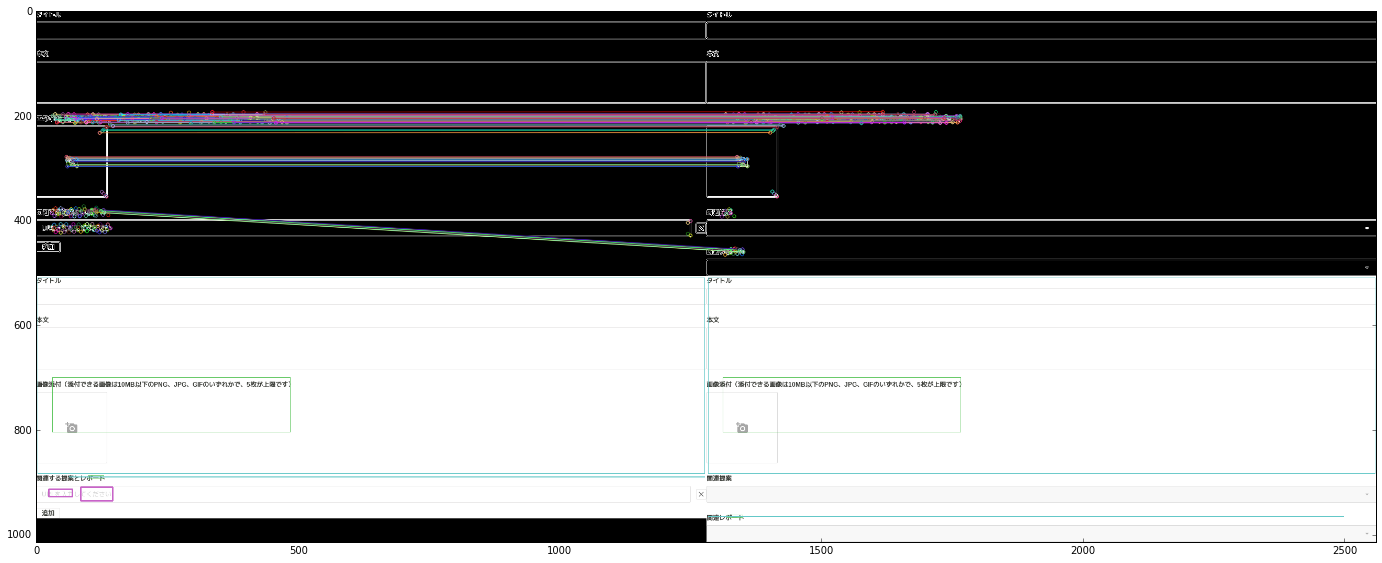

In [13]:
#detect_diff('ut/cmp/should fetch similar sites.png')
#detect_diff('ut/cmp/checkboxes.png')
#detect_diff('ut/cmp/modal_submit.png')
detect_diff('ut/cmp/topic_form.png')
#detect_diff('out-entrylist/13/screenshot-pc.png')
#detect_diff('tweetdeck.png')


Start to process:  tweetdeck.png
The num of keypoints(img1):   40008
The num of keypoints(img2):   39470
The num of matched:  33137 33171
Sumpling to  400
[(135, 805, 618, 1295), (39, 29, 2768, 1362)]
[(135, 135, 618, 625), (39, 29, 2768, 1362)]
Quantized translation vectors:  [(0, 0)]
[(39, 29, 2768, 1362)] [(39, 29, 2768, 1362)]
End to process:  tweetdeck.png

Start to process:  ut/cmp/should fetch similar sites.png
The num of keypoints(img1):   4863
The num of keypoints(img2):   4418
The num of matched:  3853 3861
Sumpling to  400
[(41, 180, 1185, 377), (47, 938, 1085, 1071), (42, 406, 1215, 549), (65, 29, 201, 34), (60, 785, 975, 909), (69, 593, 1184, 737)]
[(41, 117, 1185, 314), (47, 875, 1085, 1008), (42, 343, 1215, 486), (65, 29, 201, 34), (60, 722, 975, 846), (69, 530, 1184, 674)]
Quantized translation vectors:  [(0, -63), (0, -63), (0, 174), (0, -63), (0, 0), (0, -63)]
[(41, 180, 1185, 377), (47, 938, 1085, 1071), (42, 406, 1215, 549), (65, 29, 201, 34), (60, 785, 975, 909), 

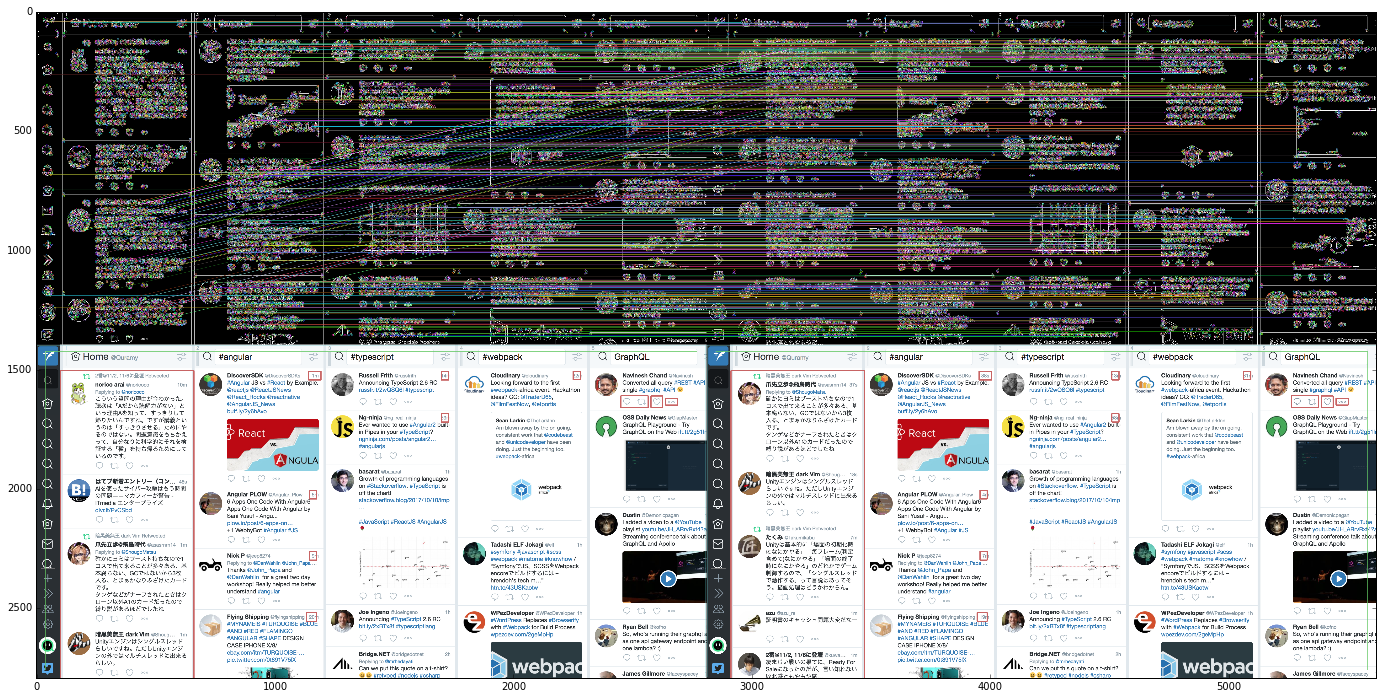

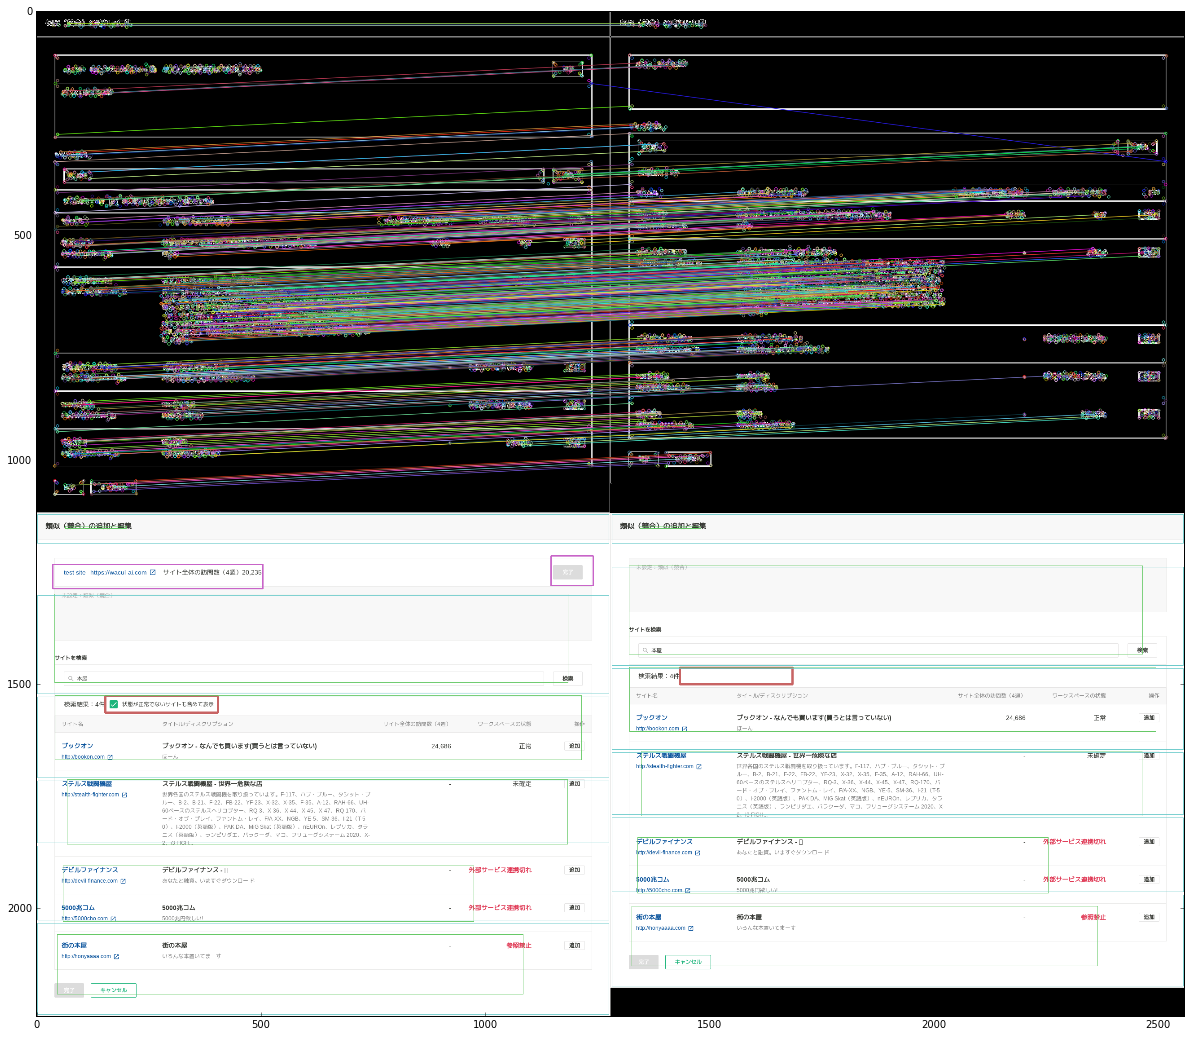

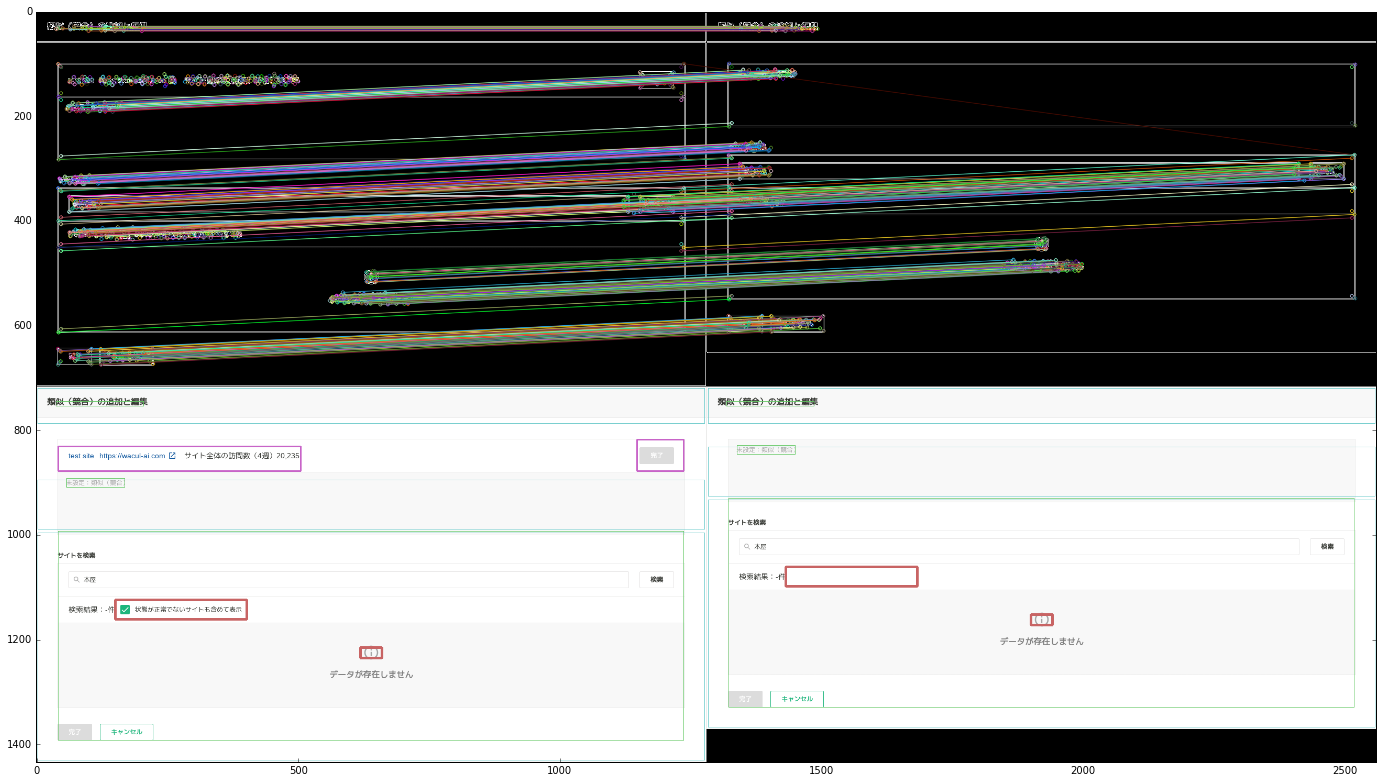

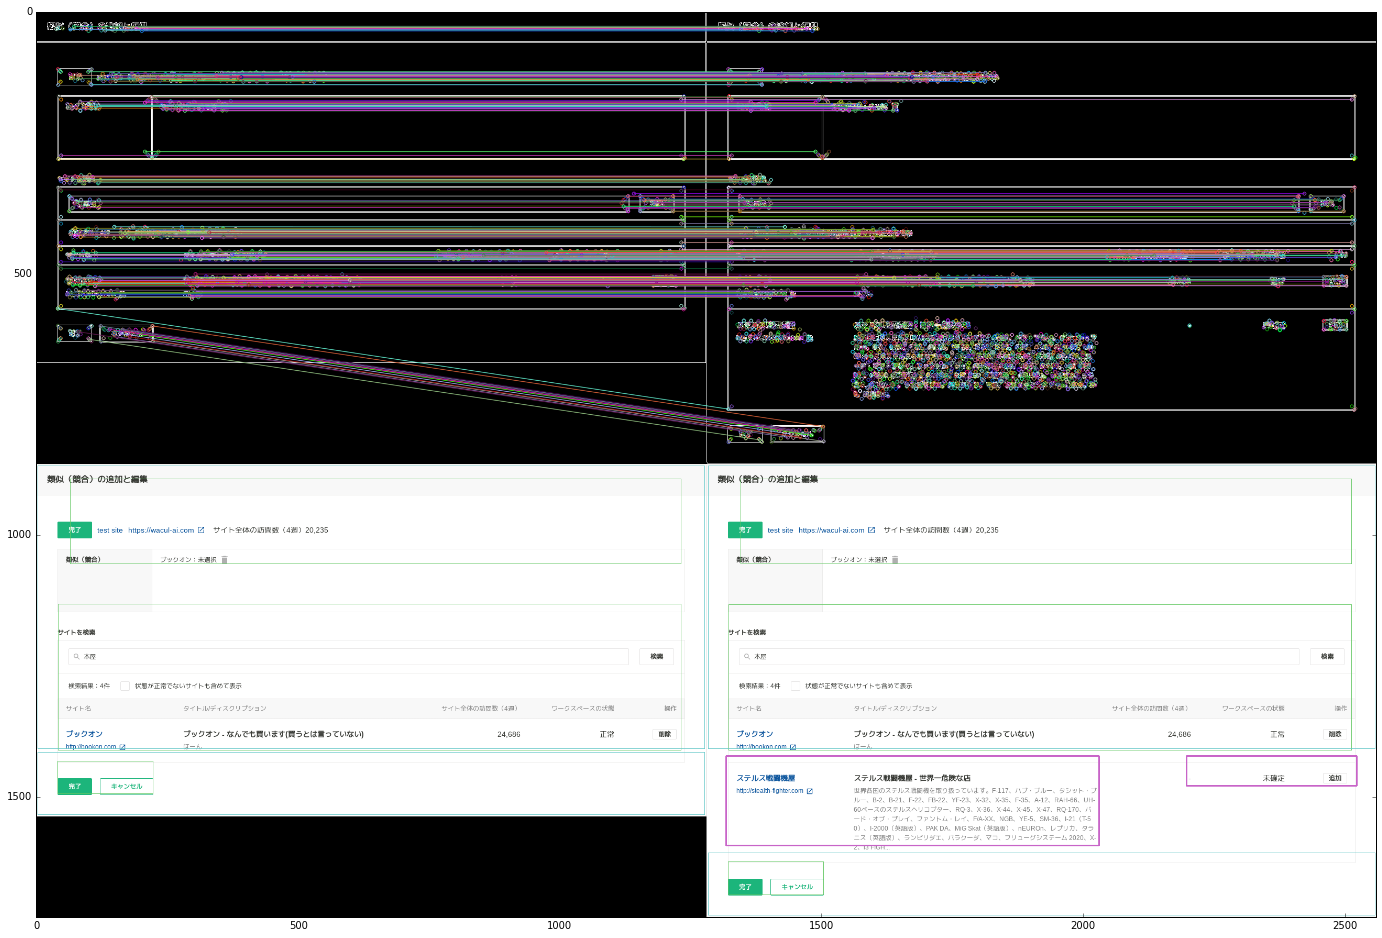

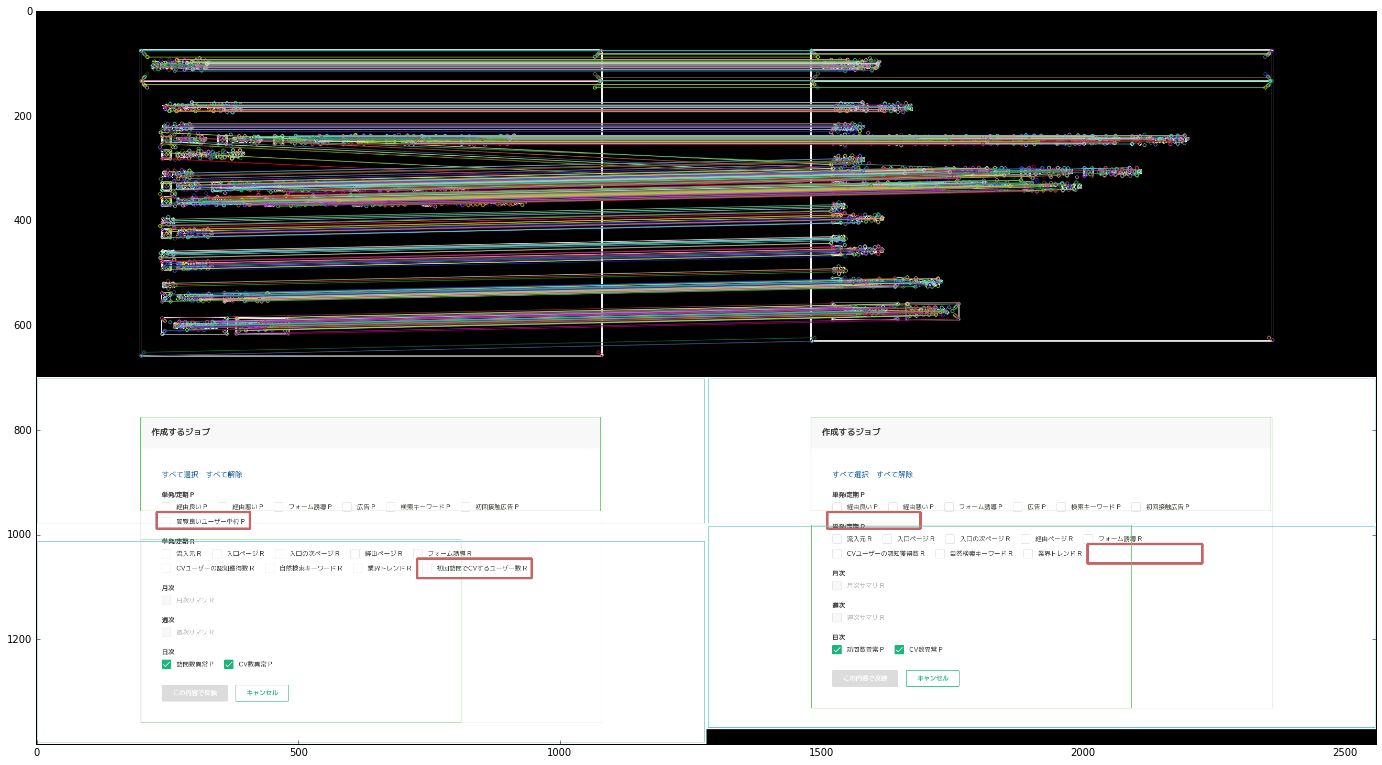

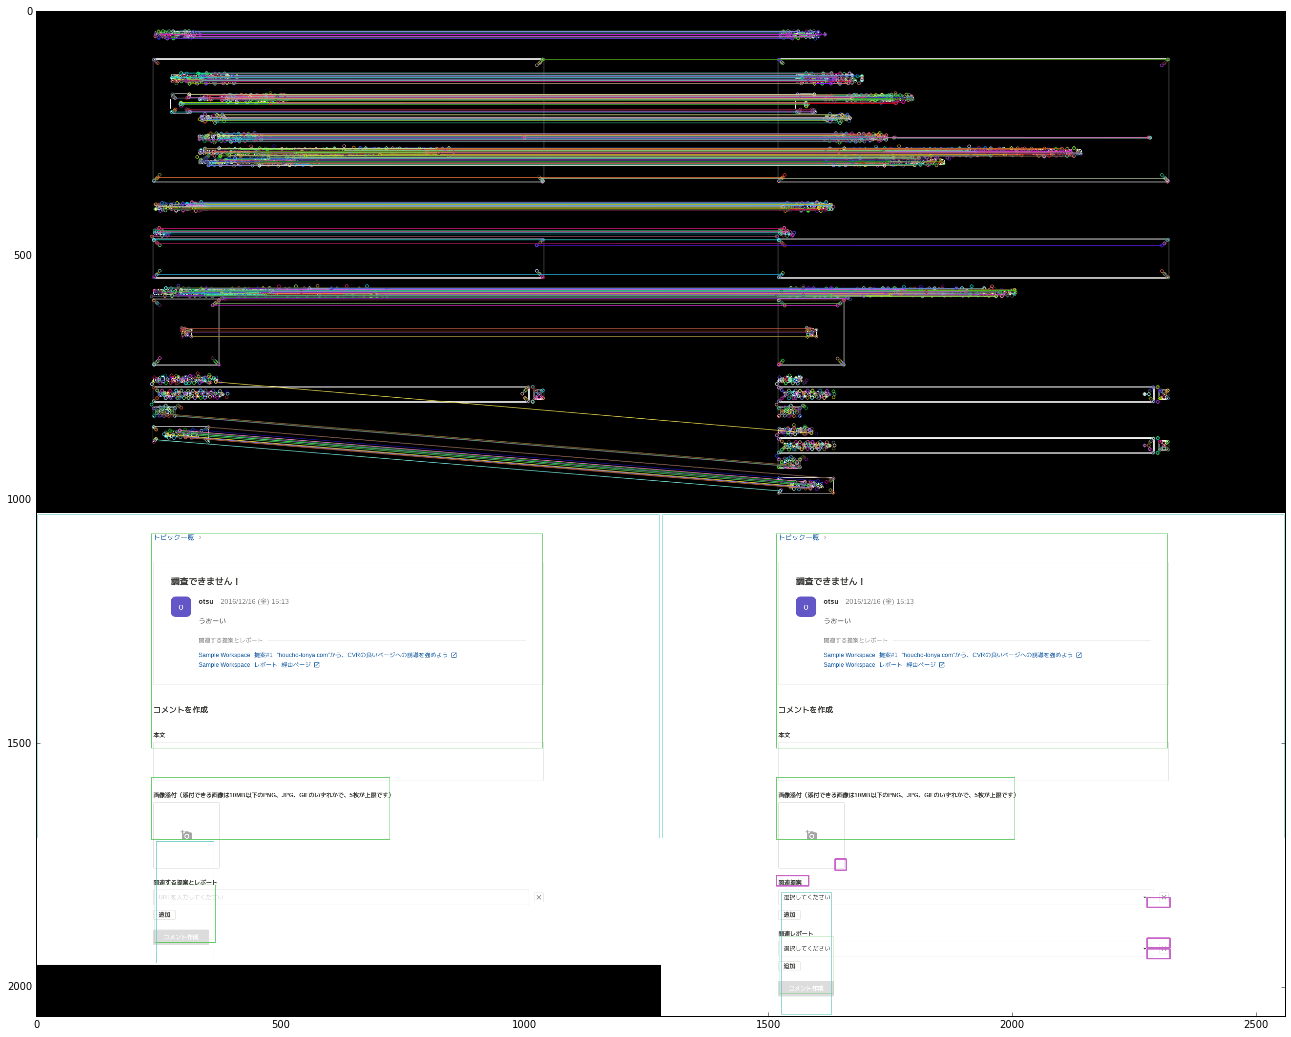

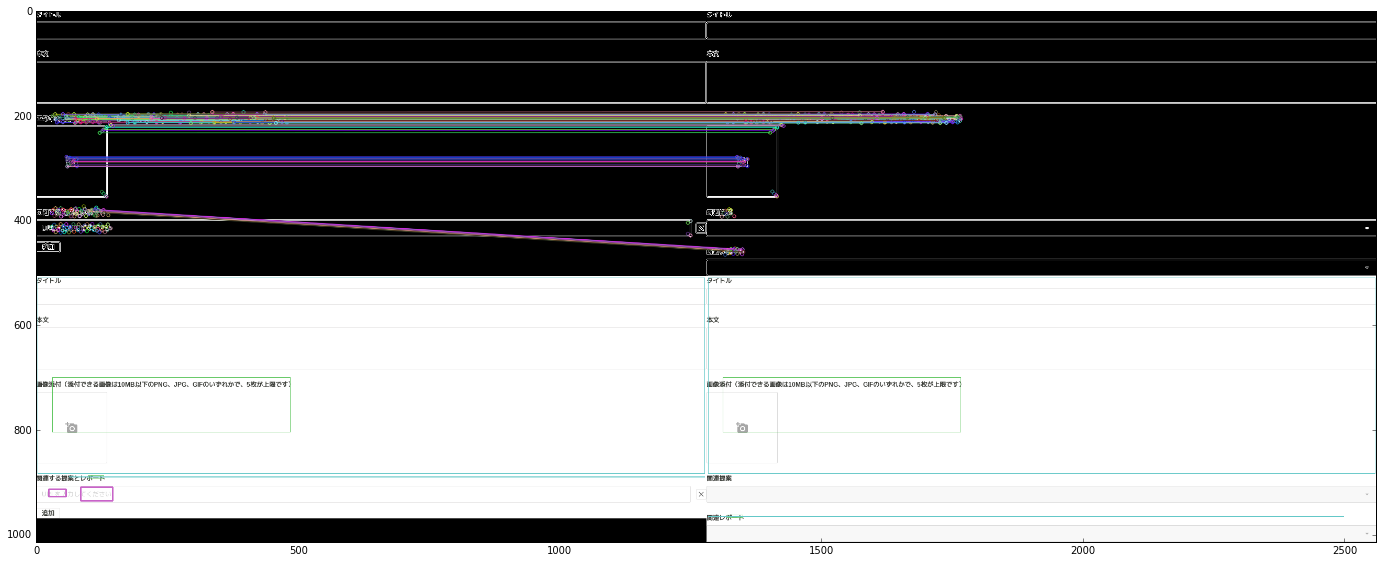

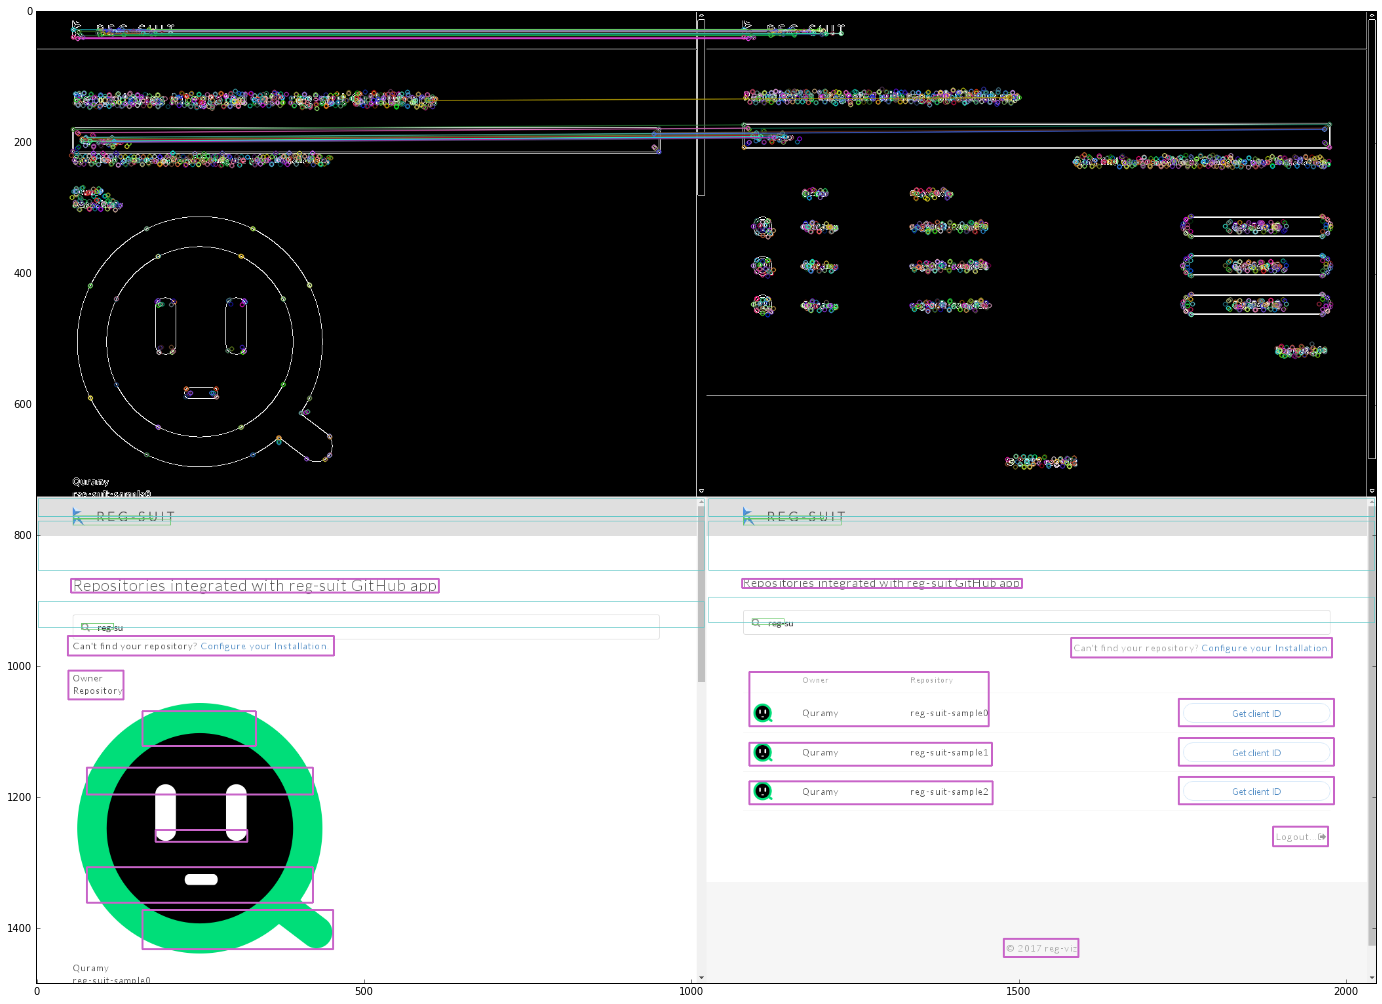

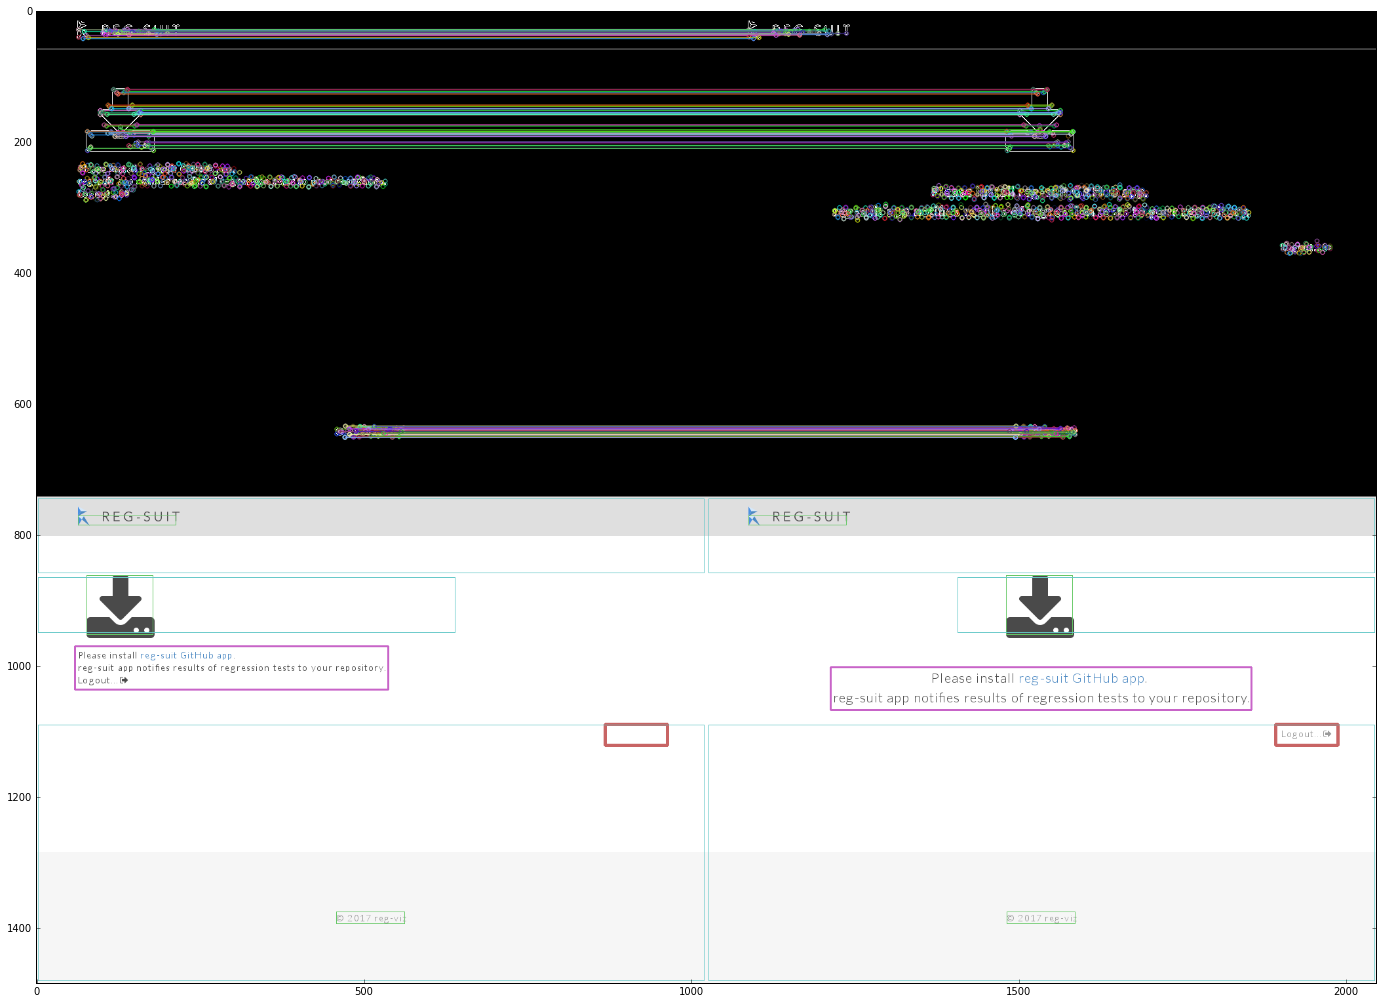

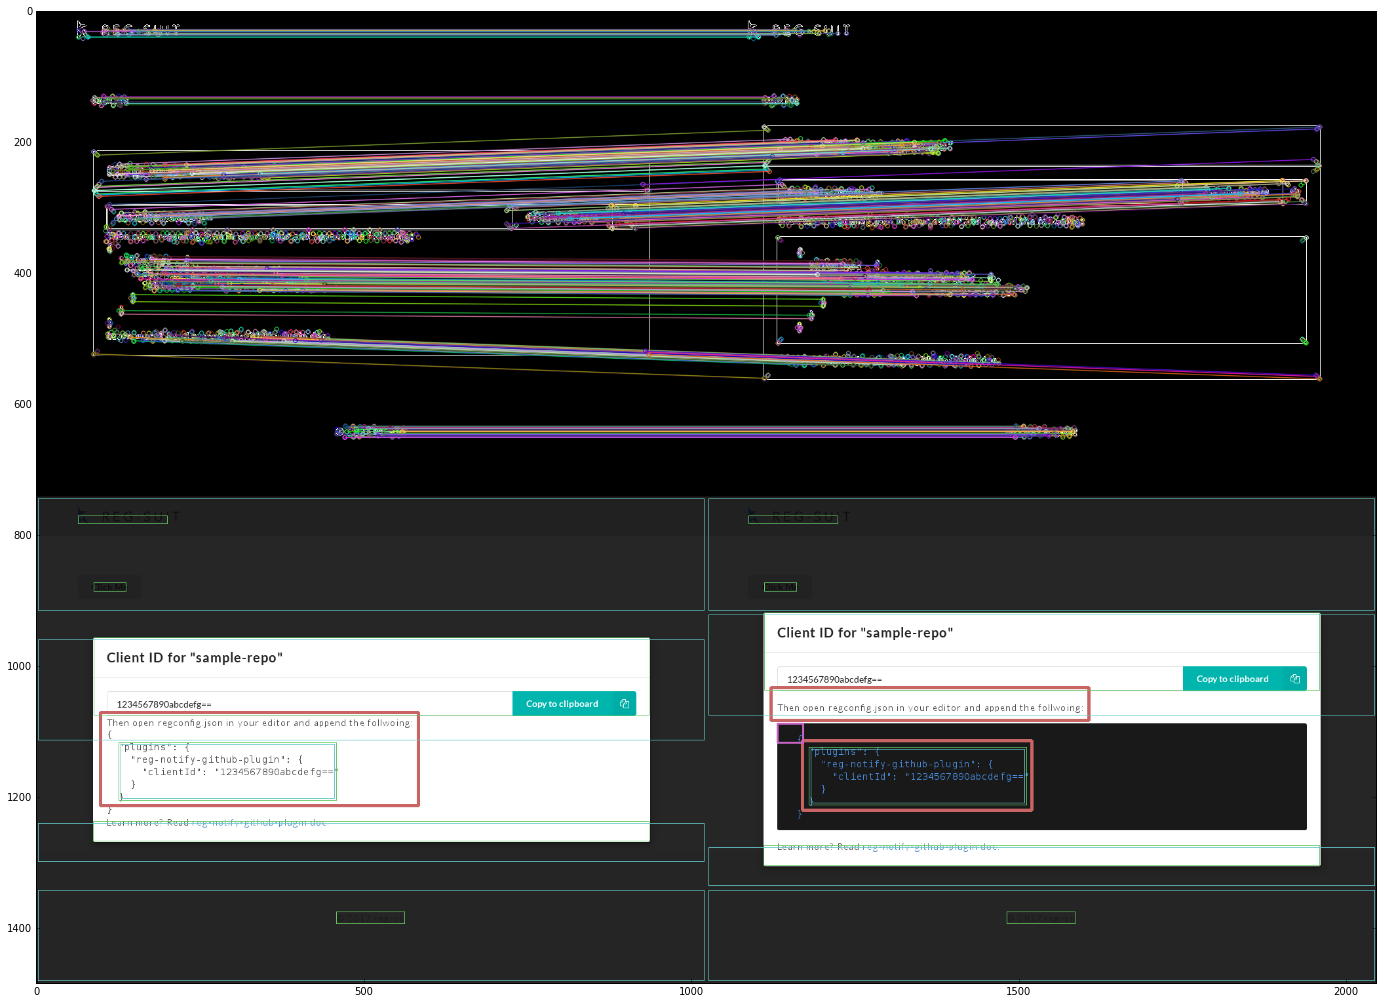

In [14]:
suffix_list = [
    'tweetdeck.png',
    'ut/cmp/should fetch similar sites.png',
    'ut/cmp/should debounce to fetch similar sites.png',
    'ut/cmp/should render similar site without invalid sites.png',
    'ut/cmp/checkboxes.png',
    'ut/cmp/modal_submit.png',
    'ut/cmp/topic_form.png',
    'gh-app-front/app_installations.png',
    'gh-app-front/app_goto_install.png',
    'gh-app-front/client-id-modal.png'
]

for suffix in suffix_list:
    detect_diff(suffix)